# Technology learning tutorial: Estimating learning and economies-of-scale parameters

In this tutorial, we will learn how this approach is implemented to estimate learning and economies-of-scale parameter of wind turbines using data from Danish wind turbines manufacturing industry.

Using the number of units, size, and investment cost historical data, learning parameter $b$ and economies-of-scale parameter $\rho$ can be estimated using an optimization model for curve-fitting, aiming to minimize estimation error.

Here, we use `pyomo` -based non-linear optimization model to estimate the parameters. Hence, before running this tutorial, please ensure that `pyomo` with non-linear solver is already installed in your environment.

Let's start the tutorial by importing necessary packages.

In [1]:
from pyomo.environ import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

The second step is reading the input data to estimate the parameters. In this approach, unit number, unit size, and specific investment cost (capex) data are required.

In [2]:
# reading data from excel
df = pd.read_excel('./data.xlsx', 
                   sheet_name=0, header=[0], 
                   skiprows=[1], usecols='A:E').dropna() # use this skip rows for CSP only *range(1,17)

df = df.reset_index(drop=True)

df.index += 1   # making index start from 1


['Cumulative Number', 'Cumulative Capacity', 'Size', 'Capex']


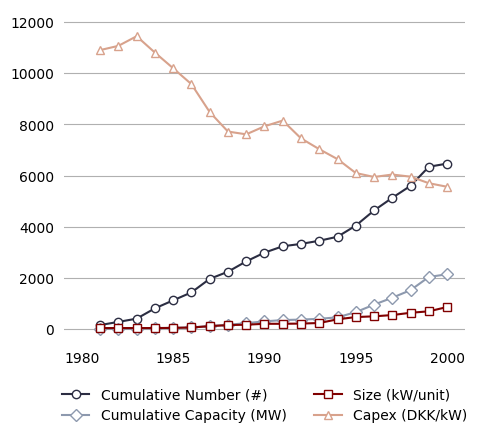

In [92]:

plot_vars = [var for var in df.columns if var != 'Year']
print(plot_vars)
plot_units = ['(#)','(MW)','(kW/unit)','(DKK/kW)']
plot_marks = ['o','D','s','^']
plot_cols = ['#2b2d42','#8d99ae','#800000','#d8a28c']
# Create a figure and axes
fig, ax = plt.subplots(figsize=(5,4.5))
for v in range(len(plot_vars)):
    plotv = ax.plot(df['Year'],df[plot_vars[v]],
                    color=plot_cols[v],
                    marker=plot_marks[v], mfc='w', 
                    label=plot_vars[v]+' '+plot_units[v])

# Remove the top and right spines
sides = ['top','bottom','left','right']
for s in sides:
    ax.spines[s].set_visible(False)

# Remove the left and bottom ticks
ax.tick_params(axis='both', which='both', 
               bottom=False, top=False, left=False, right=False)

ax.grid(axis='y')    
ax.set_xticks(range(1980,2001,5))
ax.set_xlim(1979,2001)
ax.set_ylim(-500,12500)
ax.legend(ncols=2, frameon=False,
         loc='upper center', bbox_to_anchor=(0.5, -0.1))

# Set the color of x-axis tick labels
plt.tick_params(axis='both')


plt.tight_layout() #rect=[0, 0.1, 1, 0.9]
plt.savefig('data.png', dpi=450, transparent=True)
plt.show()

Now, instead of using all the data above, let's call a set of parameters from the data that is required for parameters estimation. Afterward, let's declare the model name, model sets, parameters, and variables

In [10]:
class CallData:
    def __init__(self, name):
        self.name = name
        self.data = df[name].to_dict()          # creates a dictionary for data    

## Additional data definition
nbr_unit_data    = CallData('Cumulative Number').data      # creating list of units #
unt_size_data    = CallData('Size').data        # creating dictionary of units size
capex_tec_data   = CallData('Capex').data       # creating dictionary of investment cost

## Declare model's name
model   = ConcreteModel('Parameter Estimate')

## Define sets ##
model.n = Set(initialize=list(nbr_unit_data.keys()), doc='Units number')

## Define data and parameters ## 
model.nbr_unit_ref = Param(initialize=nbr_unit_data[1], doc='Units # set as reference')
model.unt_size_ref = Param(initialize=unt_size_data[1], doc='Units size set as reference')
model.capex_tec = Param(model.n, initialize=capex_tec_data, doc='Investment cost data')
model.nbr_unit  = Param(model.n, initialize=nbr_unit_data, doc='Units # data')
model.unt_size  = Param(model.n, initialize=unt_size_data, doc='Units size data')

## Define variables ##
model.CAPEX_TEC_ref = Var(bounds=(0.0,None), doc='Investment cost at reference units # and size')
model.ERROR         = Var(model.n, bounds=(None,None), doc='Error, i.e., delta between data and calculation')
model.ERROR_pos     = Var(model.n, bounds=(0.0,None), doc='x+ variable to make absolute number for x')
model.ERROR_neg     = Var(model.n, bounds=(0.0,None), doc='x- variable to make absolute number for x')
model.RHO           = Var(bounds=(-1,5), doc='Economy-of-scale parameter')
model.B             = Var(bounds=(-1,1), doc='Learning parameter')

Using the number of units, size, and investment cost historical data, learning parameter $b$ and economies-of-scale parameter $\rho$ can be estimated using an optimization model for curve-fitting, aiming to minimize estimation error. The objective function of this model is described in the equation below:

\begin{equation}
\label{eq: obj_estimate}
Min._{(b,\rho,ic_{ref})} = \sum_{n} \frac{x_{n}^{+} + x_{n}^{-}}{IC_{n}}
\end{equation}

with $x_{n}^+$ and $x_{n}^-$ is the absolute value of the capital cost estimation error $x$, calculated using the following equation

\begin{equation}
\label{eq: c1_estimate}
x_{n} = IC_{n} - ic_{ref} \left( \frac{N_{n}}{N_{ref}} \right)^{b-} \frac{(S_{n}/S_{ref})^{\rho}}{(S_{n}/S_{ref})} \qquad \qquad \forall{n}
\end{equation}

\begin{align}
    & x_{n} = \ x_{n}^{+} - x_{n}^{-} & \ \forall{n} \label{eq: c2_estimate} \\
    & |x_{n}| = \ x_{n}^{+} + x_{n}^{-} & \ \forall{n} \label{eq: c3_estimate}
\end{align}

Here, $x$ is calculated using specific investment cost data $IC$ for each unit $n$ with size $s$. $ic$ in the above equation is the intercept of the fitted-curve with the y-axis, which implies the estimated value of the reference plant's specific investment cost.

\begin{align}
    & x_{n}^{+}, \ x_{n}^{-}, \ b, \ \rho \geq 0 & \ \forall{n} \label{eq: c4_estimate} \\
    & \rho \leq \ 1 & \ \forall{n} \label{eq: c5_estimate}
\end{align}

In [11]:
## Define constraints ##
def error_rule(model, n):
  return model.ERROR[n] == (model.capex_tec[n] 
                        - (model.CAPEX_TEC_ref * ((model.nbr_unit[n]/model.nbr_unit_ref)**(-model.B)) 
                           * (model.unt_size[n]/model.unt_size_ref)**(model.RHO)
                           / (model.unt_size[n]/model.unt_size_ref)))
model.error = Constraint(model.n, rule=error_rule, doc='Error calculation')

def errorabs_rule(model, n):
  return model.ERROR[n] == model.ERROR_pos[n] - model.ERROR_neg[n]
model.errorabs = Constraint(model.n, rule=errorabs_rule, doc='Absolute x calculation')

def rhos_rule(model):
  return model.RHO <= 5
model.rhos = Constraint(rule=rhos_rule, doc='Bigger unit cannot be more expensive than smaller unit')

## Define objective functions ##
def objective_rule(model):
  return sum(((model.ERROR_pos[n] + model.ERROR_neg[n])/model.capex_tec[n])**2 for n in model.n)
model.objective = Objective(rule=objective_rule, sense=minimize, doc='Objective function in squared absolute percentage term')

Now, let's solve this model to get estimates of learning and economies-of-scale parameters

In [12]:
# This is an optional code path that allows the script to be run outside of
# pyomo command-line.  
if __name__ == '__main__':
    # This emulates what the pyomo command-line tools does
    from pyomo.opt import SolverFactory
    import pyomo.environ
    opt = SolverFactory("gams")
    opt.options['solver'] = 'minos'
    results = opt.solve(model)
model.display()

Model Parameter Estimate

  Variables:
    CAPEX_TEC_ref : Investment cost at reference units # and size
        Size=1, Index=None
        Key  : Lower : Value              : Upper : Fixed : Stale : Domain
        None :   0.0 : 11093.762830798778 :  None : False : False :  Reals
    ERROR : Error, i.e., delta between data and calculation
        Size=20, Index=n
        Key : Lower : Value               : Upper : Fixed : Stale : Domain
          1 :  None :  -184.7628307987784 :  None : False : False :  Reals
          2 :  None :   67.24425785777804 :  None : False : False :  Reals
          3 :  None :   498.1818798494191 :  None : False : False :  Reals
          4 :  None : -41.808315885531904 :  None : False : False :  Reals
          5 :  None : -218.31186995015688 :  None : False : False :  Reals
          6 :  None : -186.65184246855563 :  None : False : False :  Reals
          7 :  None :  -51.92964248543743 :  None : False : False :  Reals
          8 :  None :  -224.81017

What is the value of learning parameter, economies-of-scale parameter, and the intercept (reference capex)?

In [13]:
obj             = model.objective(value)
b               = model.B(value)
rho             = model.RHO(value)
CAPEX_TEC_est   = model.CAPEX_TEC_ref(value)

print('learning parameter           :',round(b,3))
print('economies of scale parameter :',round(rho,3))
print('reference capex (intercept)  :',round(CAPEX_TEC_est,1))

learning parameter           : 0.013
economies of scale parameter : 0.794
reference capex (intercept)  : 11093.8


Now let's see them in a plot

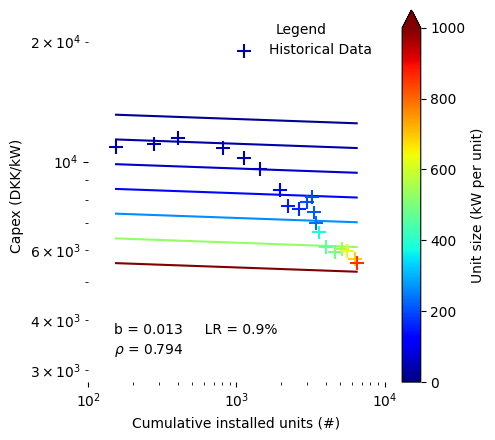

In [90]:
## plottings

fig, axs = plt.subplots(figsize=(5,4.5))
layer_1 = axs.scatter(df['Cumulative Number'].to_list(), df['Capex'].to_list(), s=100, marker='+', 
            cmap='jet', facecolor='None',vmin=0, vmax=1000, c=df['Size'], label='Historical Data',zorder=2)
for e in range(4,11):
    EST_LINE  = [CAPEX_TEC_est*(nbr_unit_data[int(x)]/nbr_unit_data[1])**(-b)*(((2**e)/unt_size_data[1])**(rho))
                 /((2**e)/unt_size_data[1]) for x in [*range(1,len(df['Cumulative Number'])+1)]]
    layer_2 = axs.plot(df['Cumulative Number'],EST_LINE,c=plt.cm.jet(np.int32(((2**e)/1000)*265)),
                       lw=1.5,zorder=1,ls='-') 
    
axs.set_ylim(2800,24000)
axs.set_xlim(100,10000)
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_ylabel('Capex (DKK/kW)')
axs.set_xlabel('Cumulative installed units (#)')

#axs.text(400,4300,'Capex$_{ref}$ = DKK '+str(int(CAPEX_TEC_est))+'/kW')
axs.text(150,3700,'b = '+str(round(b,3))+'     LR = '+str(round(100*(1-2**(-b)),1))+'%')
axs.text(150,3300 ,r'$\rho$ = '+str(round(rho,3)))
#axs.grid(axis='y', which='both', linestyle='-',lw=1)    

# Remove the top and right spines
sides = ['top','bottom','left','right']
for s in sides:
    axs.spines[s].set_visible(False)

# Remove the left and bottom ticks
axs.tick_params(axis='both', which='both', 
               bottom=True, top=False, left=True, right=False)

# plot and set the colorbar
cb = (fig.colorbar(layer_1, fraction=0.1, orientation='vertical', extend='max')
      .set_label(label='Unit size (kW per unit)',size=10))
# Rotate the tick labels and set their alignment.
plt.setp(axs.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")


    
plt.legend(title='Legend',ncol=2,frameon=False)
plt.tight_layout()
plt.show()
fig.savefig('learning.png', dpi=450,transparent=True)

Thank you for following this tutorial!